## Studying the Types of Chardonnay/Sauvignon

### 1. Introduction

This notebook can be used to study the different types of wine within a given grape variety - in this case, Chardonnay. We cover a new & refined way of generating descriptors from our raw dataset based on wine theory. Subsequently, we generate features from the extracted set of descriptors, and use clustering methods friendly to categorical data to find how many distinct types of Chardonnay may exist. Finally, we do some exploratory data analysis to learn more about the characteristics of each of the derived clusters.

## Install those librairies 

conda install -c conda-forge proj4 

pip install wordcloud

pip install basename ou conda install basemap

pip install geopy nominatim

## Change the file `wine_visuals_custom_val.py`

Add the path of the proj4 library in the variable `PROJ_LIB`

```python 
os.environ['PROJ_LIB'] = '/Users/Valou/anaconda3/pkgs/proj4-5.2.0-h0a44026_1/share/proj/'
```

with the path of this lib in your own machine 

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import itertools
from operator import itemgetter
import warnings
import string
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

from geopy.geocoders import Nominatim

from wine_visuals_custom_val import generate_wordcloud, generate_bar_chart, gen_map, generate_cluster_visual, generate_histogram, generate_descriptor_info # Python file containing the code for the visualizations produced in this notebook

from normalizing_text import load_text_normalization_objects, full_text_normalization # Python file containing the text normalization functions used to extract wine descriptors from the raw wine reviews


warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
%matplotlib inline

##### 1.1 The Raw Dataset

For the purpose of this exercise, we scraped an expansive set of more than 15,000 Chardonnay wine reviews from www.winemag.com. For an overview of which attributes were mined, let us take a look at the dataframe below.

In [ ]:
raw_wine_dataset = pd.read_csv('data/all_wines_scrapped.csv')

raw_wine_dataset['variety_scrapping'].unique()

Look at the different type of wine you would like to study 

In [ ]:
raw_wine_dataset['variety_scrapping'].unique()

In [ ]:
# wine_variety = 'Sauvignon_Blanc'
wine_variety = 'Chardonnay'

raw_wine_dataset = raw_wine_dataset[raw_wine_dataset['variety_scrapping'] == wine_variety]

In [2]:
print(len(raw_wine_dataset))
raw_wine_dataset = raw_wine_dataset.loc[raw_wine_dataset['Category'] == 'White']
print(raw_wine_dataset.shape)
raw_wine_dataset.head()

12627
(12486, 20)


,Name,Category,Variety,Appellation,Country,Province,Region,Subregion,Winery,Designation,Vintage,Bottle Size,Alcohol,Description,Date Published,Price,Rating,Reviewer,User Avg Rating,url
0,Stephen Vincent 2005 Sauvignon Blanc (California),White,Sauvignon Blanc,"California, California Other, California, US",US,California,California Other,California,Stephen Vincent,NaN,2005.0,750 ml,NaN,"A nicely fruited, crisp wine that lots of peo...",5/1/2007,$10,83,,Not rated yet [Add Your Review],https://www.winemag.com/buying-guide/stephen-v...
1,Strauss 2015 Classic Sauvignon Blanc (Südsteie...,White,Sauvignon Blanc,"Südsteiermark, Austria",Austria,Südsteiermark,NaN,NaN,Strauss,Classic,2015.0,750 ml,12.5%,Slight notes of grass and stone fruit on the ...,9/1/2016,$18,90,Anne Krebiehl MW,Not rated yet [Add Your Review],https://www.winemag.com/buying-guide/strauss-2...
2,Charles Krug 2004 Peter Mondavi Family Sauvign...,White,Sauvignon Blanc,"Napa Valley, Napa, California, US",US,California,Napa,Napa Valley,Charles Krug,Peter Mondavi Family,2004.0,750ML,13.4%,"Crisp and clean, with aromas and flavors that...",12/31/2005,$16,87,,Not rated yet [Add Your Review],https://www.winemag.com/buying-guide/charles-k...
3,Bodega Norton 2010 Sauvignon Blanc (Mendoza),White,Sauvignon Blanc,"Mendoza, Mendoza Province, Argentina",Argentina,Mendoza Province,Mendoza,NaN,Bodega Norton,NaN,2010.0,750 ml,13%,Neutral on the nose except for a spot of peac...,5/1/2011,$10,83,Michael Schachner,Not rated yet [Add Your Review],https://www.winemag.com/buying-guide/bodega-no...
4,Viu Manent 2008 Sauvignon Blanc (Colchagua Val...,White,Sauvignon Blanc,"Colchagua Valley, Chile",Chile,Colchagua Valley,NaN,NaN,Viu Manent,NaN,2008.0,750 ml,12.5%,Aromas of grapefruit and other citrus fruits ...,7/1/2009,$9,84,Michael Schachner,Not rated yet [Add Your Review],https://www.winemag.com/buying-guide/viu-manen...


To allow for analysis later on in this notebook, we will also compute the age of each wine when it was reviewed. This will allow us to study how aging impacts the wines in our dataset.

In [3]:
raw_wine_dataset['Review_year'] = pd.DatetimeIndex(raw_wine_dataset['Date Published']).year
raw_wine_dataset['Age'] = raw_wine_dataset['Review_year'] - raw_wine_dataset['Vintage']

### 2. Preparing Features

##### 2.1 Extracting Descriptors from the Wine Descriptions

The next step in our analysis is to extract descriptors from the wine descriptions. The process by which this is conducted is largely the same as in the previous chapter of this analysis, to be found at https://github.com/RoaldSchuring/Wine-Blind-Tasting-Algorithm/blob/master/predicting_grape_varieties.ipynb. Similarly to this first exercise, we are interested in extracting only descriptors that could reasonably be derived through blind tasting. 

One important improvement versus the previous chapter of this work is that the mapping of normalized words onto descriptors is more sophisticated. After the words in each description are normalized, they are mapped against a 'classification table' that can yield three levels of descriptors.

This mapping was generated manually by studying a variety of wine descriptor definitions and wine tasting wheels. Normalized words & phrases that have little meaning in the world of wine or that are ambiguous (e.g. the term 'acid' by itself may refer to low acid, high acid, or anything in between) were removed entirely.

In [4]:
wine_term_mapping = pd.read_csv('chardonnay_descriptors.csv')
wine_term_mapping.head(10)

,descriptor_raw,descriptor_level_1,descriptor_level_2,descriptor_level_3
0,fruit,fruit,fruit,fruit
1,rich,body,rich,rich
2,ripe,fruit,ripe,ripe
3,pear,fruit,tree fruit,pear
4,toast,oak,toast,toast
5,pineappl,fruit,tropical fruit,pineapple
6,crisp,acid,high acid,crisp
7,peach,fruit,stone fruit,peach
8,miner,inorganic,minerality,minerality
9,vanilla,oak,vanilla,vanilla


The above shows that three levels of descriptors are available, going from general to specific. We can demonstrate how these categories work by using the normalized word 'apple' as an example:

Normalized word: apple
1. Level 1: Fruit
2. Level 2: Tree Fruit
3. Level 3: Apple

For now, we will extract the level 2 and level 3 descriptors from our text - we will use these for different purposes later on in our analysis.

In [5]:
sno, descriptor_mapping, punctuation_table, unknowable_tokens = load_text_normalization_objects(raw_wine_dataset)

wine_description = "Loads of fresh and tropical aromas of pineapple, orange, pear and a hint of guava show on the nose of this bottling by the Riboli family."
print(wine_description)
print('')

normalized_description_level_1 = full_text_normalization(wine_description, sno, descriptor_mapping, punctuation_table, unknowable_tokens, descriptor_mapping_level=1)
print('Level 1 wine descriptors:', sorted(normalized_description_level_1))

normalized_description_level_2 = full_text_normalization(wine_description, sno, descriptor_mapping, punctuation_table, unknowable_tokens, descriptor_mapping_level=2)
print('Level 2 wine descriptors:', sorted(normalized_description_level_2))

normalized_description_level_3 = full_text_normalization(wine_description, sno, descriptor_mapping, punctuation_table, unknowable_tokens, descriptor_mapping_level=3)
print('Level 3 wine descriptors:', sorted(normalized_description_level_3))

Loads of fresh and tropical aromas of pineapple, orange, pear and a hint of guava show on the nose of this bottling by the Riboli family.

Level 1 wine descriptors: ['acid', 'fruit']
Level 2 wine descriptors: ['citrus fruit', 'medium acid', 'tree fruit', 'tropical fruit']
Level 3 wine descriptors: ['fresh', 'guava', 'orange', 'pear', 'pineapple', 'tropical fruit']


Now, let us apply our descriptor extraction method to the full dataset.

In [6]:
raw_wine_dataset = raw_wine_dataset.loc[raw_wine_dataset['Description'].str.len() > 5]
raw_wine_dataset['descriptor_level_2'] = raw_wine_dataset['Description'].apply(lambda x: full_text_normalization(x, sno, descriptor_mapping, punctuation_table, unknowable_tokens, descriptor_mapping_level=2))
raw_wine_dataset['descriptor_level_3'] = raw_wine_dataset['Description'].apply(lambda x: full_text_normalization(x, sno, descriptor_mapping, punctuation_table, unknowable_tokens, descriptor_mapping_level=3))
raw_wine_dataset[['Name', 'Description', 'descriptor_level_2', 'descriptor_level_3']].head()

,Name,Description,descriptor_level_2,descriptor_level_3
0,Stephen Vincent 2005 Sauvignon Blanc (California),"A nicely fruited, crisp wine that lots of peo...","[sweet, high acid, fruit, sweet finish]","[sweet, crisp, fruit, sweet finish]"
1,Strauss 2015 Classic Sauvignon Blanc (Südsteie...,Slight notes of grass and stone fruit on the ...,"[high acid, grass, stone, light-bodied, stone ...","[zesty, grass, stone, light-bodied, stone frui..."
2,Charles Krug 2004 Peter Mondavi Family Sauvign...,"Crisp and clean, with aromas and flavors that...","[clean, high acid, citrus fruit, medium acid]","[grapefruit, nectarine, refreshing, tart, clea..."
3,Bodega Norton 2010 Sauvignon Blanc (Mendoza),Neutral on the nose except for a spot of peac...,"[low tannin, citrus fruit, stone fruit, mealy,...","[chunky, citrus, grapefruit, peach, passion fr..."
4,Viu Manent 2008 Sauvignon Blanc (Colchagua Val...,Aromas of grapefruit and other citrus fruits ...,"[citrus fruit, medium acid, pickled, herb, aci...","[citrus, grapefruit, pickled, fresh, herb, fruit]"


##### 2.2 Turning Descriptors into Features

Before we can start building clusters of different wine descriptors, we need to convert our wine descriptors to features. We should consider for a moment which level of descriptors (2 or 3) we want to use to generate our clusters. While level 3 is more specific, we may end up with overly differentiated observations. Level 2 will allow us to paint in broader strokes, but we risk losing levels of detail that are important in understanding the differences between specific types of Chardonnay.

After observing the clusters produced by both levels of descriptors, level 2 appeared to be more productive at this stage. We will therefore use level 2 descriptors to generate features for clustering. The way we will do this is through the creation of dummy variables indicating the presence/absence of a given descriptor for each observation.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
normalized_wine_dataset = raw_wine_dataset[['descriptor_level_2']]

list_desc = [[str(l) for l in k[0]] for k in normalized_wine_dataset.values.tolist()]

cv = CountVectorizer()
# list_desc = [['citrus fruit', 'medium acid', 'tree fruit', 'tropical fruit'],
#     ['citrus fruit', 'strong acid', 'tree fruit', 'minerality']]
X = cv.fit_transform([' '.join([kk.replace(' ', '_') for kk in k]) for k in list_desc])

final_wine_dataset = pd.DataFrame(np.asarray(X.todense()), columns= cv.get_feature_names(), index=normalized_wine_dataset.index)

print(final_wine_dataset.shape)
final_wine_dataset.head()

(12438, 269)


,acid_finish,angular,anise,asian_spice,attractive_acid,austere,baked_bread,baking_spices,barrel_flavor,beeswax,...,wet_stone,white_fruit,wood,wood_grill,wood_spice,yeast,yellow,yellow_flower,yellow_fruit,yoghurt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For easier exploratory analysis, let us remove any descriptors that appear in fewer than 10 observations. In addition, we will remove any observations that have fewer than 5 descriptors. 

In [10]:
final_wine_dataset_filtered_columns = final_wine_dataset.drop([col for col, val in final_wine_dataset.sum().iteritems() if val < 10], axis=1)
print(final_wine_dataset_filtered_columns.shape)

final_wine_dataset_filtered_rows = final_wine_dataset_filtered_columns.loc[final_wine_dataset_filtered_columns.sum(axis=1) >= 5]
print(final_wine_dataset_filtered_rows.shape)

(12438, 227)
(10067, 227)


### 3. Clustering

##### 3.1 Choosing the Right Clustering Technique

Since our dataset consists solely of categorical variables, it is worth spending a moment discussing which clustering technique(s) we should be using. The classic clustering technique is K-Means, a process by which observations are iteratively assigned to a cluster based on the closest cluster centroid. These centroids are computed as the mean of all observations contained within them. However, the concept of 'distance' - which is used to determine cluster membership - is different in the case of categorical variables. As such, we have to explore alternative clustering methods.

Two of such methods that were explored are K-Modes and the ROCK clustering algorithm. K-Modes is largely similar to K-Means, but uses modes instead of means to form clusters. For more on the K-Modes algorithm, check out the following article https://analyticsdefined.com/using-k-modes-clustering-categorical-data/. Unlike K-Modes, the ROCK clustering algorithm is an agglomerative clustering algorithm. The first step of the ROCK algorithm is to assign a cluster to each data point. 'Links' are then computed between each data point, and clusters are merged based on the quality of these links. This iterative process continues until (i) a specified number of clusters has been reached, or (ii) no more linkages exist. 

After trying both of these options, it appeared that K-Modes yielded slightly better clusters. As such, we will proceed with this algorithm for the purpose of this analysis, but it could be worth exploring ROCK in more detail for a future chapter of this analysis.

##### 3.2 Evaluating our Clusters & Choosing the Right K

It is also worth considering what we are looking for in our clusters. We would like each of our clusters to have substantive membership, and not have 99% of all observations lie in the same cluster. In addition and on a related note, we will disregard clusters with only one observation. At this stage, we are interested in identifying the main types of Chardonnay, and are less interested in one-off wines that fall outside the existing norms. 

We want the clusters to be as differentiated as possible. We want to maximize the similarity of observations within a cluster, and minimize the similarity of observations between clusters. To do this, we will employ two methods: the average silhouette score and the scree plot. A silhouette score can be computed for every observation. A higher value indicates better membership to its assigned cluster relative to other clusters. The average silhouette score across all clusters can tell us how well the data has been clustered. We will plot the average silhouette score for the various values of k we will consider. We will look to choose a value for k that yields as high an average silhouette score as possible.

To produce the scree plot, we will compute the square of the distance of each data point to the mean of its cluster. Summing this across all data points give us the sum of squared distances, something we can again plot for each value of k. This is the scree plot. We will look to choose a value for k that lies at an 'elbow' of the scree plot, providing a low sum of squared distances without excessive parsing of our dataset into a multitude of clusters.

For n_clusters = 2 the average silhouette_score is : 0.07149205805197256 and the sum of squared distances is : 52317.49932686782
Counter({0: 7100, 1: 2967})

For n_clusters = 3 the average silhouette_score is : 0.05525247522205095 and the sum of squared distances is : 50334.68992581452
Counter({1: 3626, 0: 3482, 2: 2959})

For n_clusters = 4 the average silhouette_score is : 0.03754357359353075 and the sum of squared distances is : 49308.40885205582
Counter({3: 2958, 0: 2856, 2: 2146, 1: 2107})

For n_clusters = 5 the average silhouette_score is : 0.05820114256887867 and the sum of squared distances is : 48428.025141401704
Counter({2: 3416, 0: 2140, 1: 1548, 4: 1547, 3: 1416})

For n_clusters = 6 the average silhouette_score is : 0.051669816292036985 and the sum of squared distances is : 47393.59273714958
Counter({2: 2355, 1: 2286, 3: 1534, 0: 1488, 4: 1382, 5: 1022})

For n_clusters = 7 the average silhouette_score is : 0.0503573411185206 and the sum of squared distances is : 46644.01

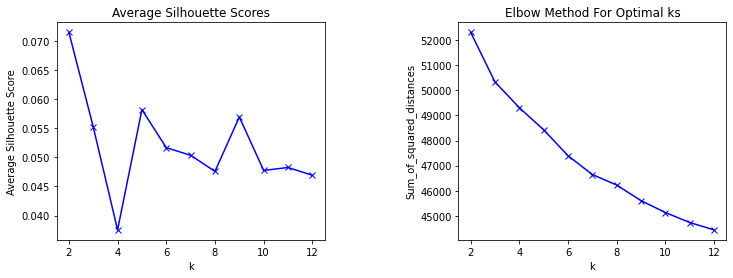

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sum_of_squared_distances = []
average_silhouette_scores = []
K = range(2, 13)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(final_wine_dataset_filtered_rows)
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(final_wine_dataset_filtered_rows, cluster_labels)
    ssd_cost = km.inertia_
    print("For n_clusters =", k,
          "the average silhouette_score is :", silhouette_avg, "and the sum of squared distances is :", ssd_cost)
    average_silhouette_scores.append(silhouette_avg)
    sum_of_squared_distances.append(ssd_cost)
    label_counts = Counter(cluster_labels)
    print(label_counts)
    print('')

plt.figure(figsize=(12, 4))    

plt.subplot(1, 2, 1)
plt.plot(K, average_silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Scores')

plt.subplot(1, 2, 2)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal ks')

plt.subplots_adjust(wspace=0.5)

plt.show()

In [24]:
best_clusters = np.sort((np.argsort(average_silhouette_scores)[::-1]+2)[:4])
best_clusters

array([2, 3, 5, 9])

##### 3.2 Choosing the Right K

There appear to be a couple of potential candidates for k, based on the average silhouette scores and the scree plot. k=5, k=6, and k=8 all appear to be plausible choices. Despite having rather low average silhouette scores, these values for k all lie at potential 'elbows' of the scree plot. Furthermore, these values for k all yield clusters that have multiple groups with more than 1 observation per cluster (k=5 yields 3 clusters with > 1 observation, k=6 yields 4, k=8 yields 5).

We should investigate these shortlisted options further. We can do this by taking a closer look at the silhouette scores for the observations within each cluster. By producing a graphical representation of these silhouette scores, we can see how well-defined the clusters are for each of our values of k. If the clusters contain many observations with low or even negative silhouette scores, we may choose an alternative value for k. In addition, we can use this methodology to look which clusters are most worth singling out for further investigation (the ones with the highest silhouette scores!).

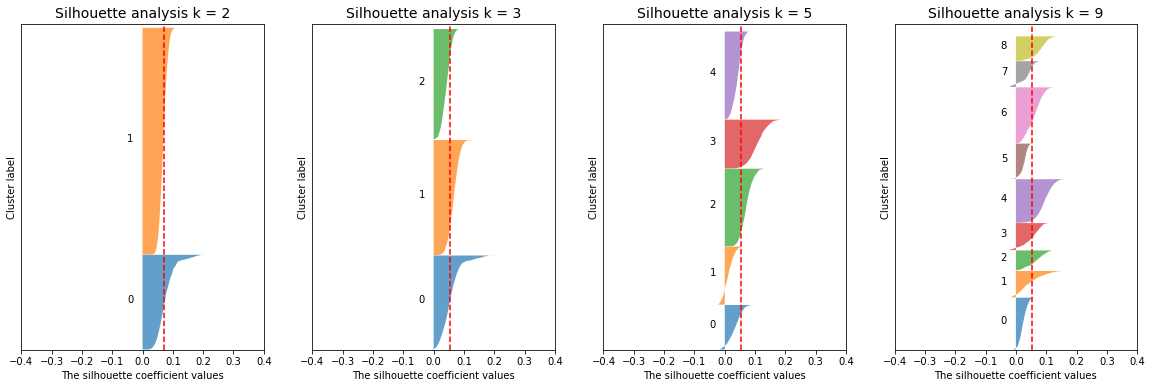

In [23]:
kms = {}
for n_clusters in best_clusters:
    kms[n_clusters] = KMeans(n_clusters=n_clusters)
    kms[n_clusters].fit(final_wine_dataset_filtered_rows)

plt.figure(figsize=(20, 6))

n = 0
for k, km_model in kms.items():
    n+=1
    cluster_labels = km_model.labels_
    sample_silhouette_values = silhouette_samples(final_wine_dataset_filtered_rows, cluster_labels)
    silhouette_avg = silhouette_score(final_wine_dataset_filtered_rows, cluster_labels)
    
    y_lower = 10
    ax = plt.subplot(1, len(kms), n)   

    ax.set_xlim([-0.4, 0.4])
    ax.set_ylim([0, len(final_wine_dataset_filtered_rows) + (k + 1) * 50])
    
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        if len(ith_cluster_silhouette_values) == 1:
            continue
        
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])

    plt.title(("Silhouette analysis k = %d" % k),
                 fontsize=14)

plt.show()

All clusters are characterized by rather low silhouette scores. Nevertheless, it appears that k = 5 yields the most distinctive clusters.

Before we dive in and start studying our newly found clusters, we will eliminate any samples with silhouette scores below 0. Such observations appear to better belong to a different cluster and have the potential to detract from our findings about individual clusters. 

In [46]:
n_clusters_final = 3
cluster_labels = [0, 1, 2]

In [47]:
cluster_all_labels = list(kms[n_clusters_final].labels_)
sample_silhouette_values = silhouette_samples(final_wine_dataset_filtered_rows, cluster_all_labels)

final_wine_dataset_filtered_rows['silhouette_score'] = list(sample_silhouette_values)
final_wine_dataset_filtered_rows['cluster_label'] = cluster_all_labels
cluster_labels_and_silhouette_scores = final_wine_dataset_filtered_rows[['silhouette_score', 'cluster_label']]

clustered_dataset = pd.merge(left=raw_wine_dataset, right=cluster_labels_and_silhouette_scores, left_index=True, right_index=True)
only_positive_silhouette_scores = clustered_dataset.loc[clustered_dataset['silhouette_score'] > 0]

### 4. Studying our Clusters

To study our newly created clusters, we will give them names beyond just the numbers that have been assigned to them - Cluster 0 will be A, Cluster 1 is B and Cluster 4 is C. 

We can see that Cluster A contains most of our observations (65% of all wines). Clusters B and C are still sizable, making up 21% and 14% of the total dataset respectively.

In [48]:
for n, cluster in enumerate(cluster_labels):
    cluster_title = 'Cluster ' + string.ascii_lowercase[n].capitalize()
    only_one_cluster = only_positive_silhouette_scores.loc[only_positive_silhouette_scores['cluster_label'] == cluster]
    cluster_size = len(only_one_cluster.index)
    perc_total = cluster_size/len(only_positive_silhouette_scores.index)
    print(cluster_title, 'contains', str(cluster_size), 'wines (' + '{0:.0%}'.format(perc_total), 'of total)')

Cluster A contains 932 wines (13% of total)
Cluster B contains 3626 wines (49% of total)
Cluster C contains 2791 wines (38% of total)


##### 4.1 Differences in Descriptors

To explore our clusters, let us first look at the differences in descriptors. 

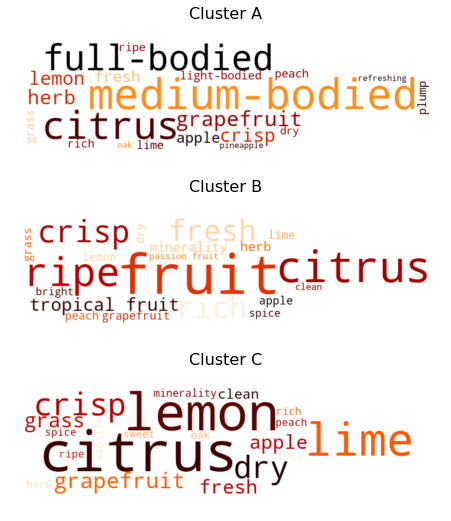

In [49]:
fig = plt.figure(figsize=(20, 9))

# cluster_labels = [0, 1, 4]
for n, cluster in enumerate(cluster_labels):
    plt.subplot(len(cluster_labels), 1, n+1)
    cluster_title = 'Cluster ' + string.ascii_lowercase[n].capitalize()
    generate_wordcloud(only_positive_silhouette_scores.loc[only_positive_silhouette_scores['cluster_label'] == cluster],
                      'descriptor_level_3', title=cluster_title)

The clusters appear to have very different descriptors feature quite prominently. The most frequent descriptors in Cluster A are tree fruit- or oak-related: apple, pear oak and toast. Cluster B wines have a similar profile, although the tree fruit descriptors from Cluster A have largely been substituted for citrus fruit descriptors (citrus, lemon, lime). Cluster C has a notably different profile, prominently featuring the terms 'rich', 'wood' and 'ripe'. Fruit descriptors are present but less pronounced in a specific direction (tree fruit or citrus fruit).

Next, let's see if we can understand this a little better by looking at the proportion of descriptors of each type (level 1 descriptors such as oak, fruit etc.) we have in each cluster.

In [50]:
for i, n in enumerate(cluster_labels):
    print('Cluster', string.ascii_lowercase[i].capitalize(), ': Descriptor Class and % of all Descriptors:')
    generate_descriptor_info(only_positive_silhouette_scores, n)
    print('')

Cluster A : Descriptor Class and % of all Descriptors:
[('fruit', '32%'), ('body', '21%'), ('acid', '14%'), ('herb', '6%'), ('inorganic', '5%'), ('oak', '4%'), ('style', '4%'), ('tannin', '3%'), ('sweetness', '3%'), ('spice', '2%'), ('microbial', '2%'), ('flower', '2%')]

Cluster B : Descriptor Class and % of all Descriptors:
[('fruit', '45%'), ('acid', '16%'), ('inorganic', '6%'), ('herb', '5%'), ('body', '5%'), ('oak', '4%'), ('tannin', '4%'), ('sweetness', '3%'), ('style', '3%'), ('spice', '3%'), ('microbial', '2%'), ('flower', '1%')]

Cluster C : Descriptor Class and % of all Descriptors:
[('fruit', '37%'), ('acid', '18%'), ('herb', '6%'), ('sweetness', '6%'), ('oak', '5%'), ('inorganic', '5%'), ('style', '4%'), ('body', '4%'), ('spice', '3%'), ('tannin', '3%'), ('microbial', '3%'), ('flower', '2%')]



It appears that all clusters contain roughly the same proportion of fruit descriptors. In fact, Clusters A and B are incredibly similar in terms of the relative frequency of specific level 1 descriptors. Cluster C stands out in terms of the proportion of 'body' descriptors. This is likely attributable to the descriptor 'rich', which was one of the standout terms in the word cloud above. Cluster C also appears to have fewer acid-related descriptors than Clusters A or B. 


##### 4.2 Differences in Geography

What are the differences in geography for our various wines? 

In order to be able to visualize the geographical data associated with our wine dataset, we need to convert the location identifiers we have into coordinates, a process called geocoding. We will use the googlemaps API for this. To run the below, you will need to substitute the API key for your own.

In [51]:
from geopy.geocoders import Nominatim

if not os.path.isfile('address_coordinates_%s.csv'%wine_variety):
    geolocator = Nominatim(user_agent="my_user_agent")

    all_addresses = list(set(only_positive_silhouette_scores['Appellation']))
    all_addresses = [a for a in all_addresses if str(a) != 'nan']

    address_coordinates = dict()
    for address in tqdm(all_addresses):
        loc = geolocator.geocode(address)
        try:
            lat = loc.latitude
            lon = loc.longitude
        except:
            lat = None
            lon = None
        address_coordinates[address] = (lat, lon)

    address_coordinates_df = pd.DataFrame.from_dict(address_coordinates, orient='index', columns=['Latitude', 'Longitude'])
    address_coordinates_df.to_csv('address_coordinates_%s.csv'%wine_variety)

In [52]:
address_coordinates_df = pd.read_csv('address_coordinates_%s.csv'%wine_variety)
address_coordinates_df.columns = ['Appellation', 'Latitude', 'Longitude']

clustered_wines = pd.merge(left=only_positive_silhouette_scores, right=address_coordinates_df, left_on=['Appellation'], right_on=['Appellation'], how='left')

Having produced coordinates for the various addresses in our dataset, we can proceed to produce a map visualization with circles indicating the frequency with which wines appear in certain locations around the world. We will also produce a couple of bar charts indicating the most common countries and provinces for the wines in each of our clusters. 

You can find the code for most of the visualizations in this notebook in the wine_visuals.py file in this notebook's repository.

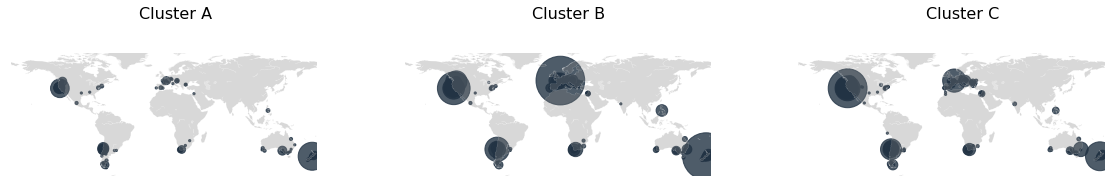

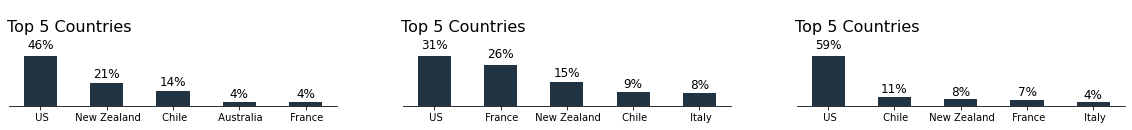

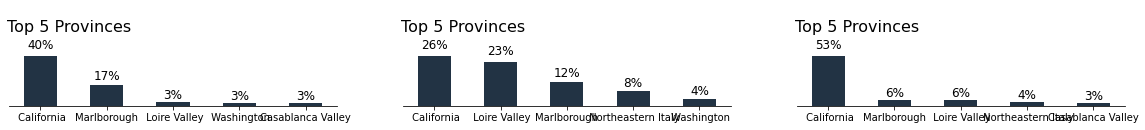

In [53]:
fig = plt.figure(figsize=(20, 5))

for n, cluster in enumerate(cluster_labels):
    plt.subplot(2, len(cluster_labels), n+1)
    cluster_title = 'Cluster ' + string.ascii_lowercase[n].capitalize()
    gen_map(clustered_wines.loc[clustered_wines['cluster_label'] == cluster], color='#223344')
    plt.text(x=-30, y=120, s=cluster_title, fontsize=16, backgroundcolor='white')
    
plt.show()

fig = plt.figure(figsize=(20, 4))

# cluster_labels = [0, 1, 4]

for n, cluster in enumerate(cluster_labels):
    plt.subplot(2, len(cluster_labels), n+1)
    generate_bar_chart(clustered_wines.loc[clustered_wines['cluster_label'] == cluster], 'Country', 'Top 5 Countries', 5, '#223344')

plt.show()


fig = plt.figure(figsize=(20, 4))

for n, cluster in enumerate(cluster_labels):
    plt.subplot(2, len(cluster_labels), n+1)
    generate_bar_chart(clustered_wines.loc[clustered_wines['cluster_label'] == cluster], 'Province', 'Top 5 Provinces', 5, '#223344')

plt.show()

Once again, Clusters A and B appear to be relatively similar, with the US (and especially California) accounting for most of the wines in these clusters. Cluster C, however, tell an entirely different story - the vast majority of these wines come from the Burgundy region in France. It speaks to the distinctiveness of the wines from this region that the k-modes algorithm, based solely on sensory descriptors, was able to segment these wines so clearly.

We are slowly starting to unveil the differences between the clusters. To dive even deeper, let's take a look at differences in a few other variables, such as age (the difference between the vintage and the date a wine was reviewed), price, rating and alcohol content.  

##### Other differences

To begin with, let's look at how the alcohol % and the age of the wines differs across clusters. 

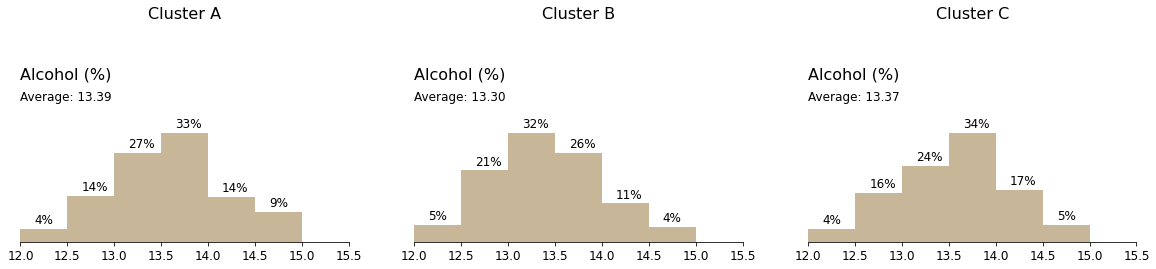

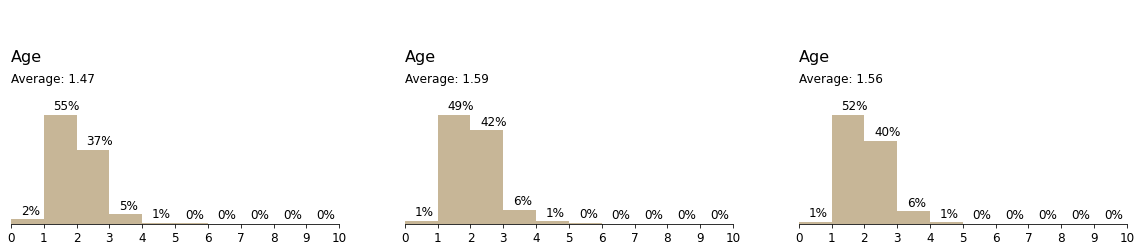

In [54]:
# cluster_labels = [0, 1, 4]

fig = plt.figure(figsize=(20, 4))
for n, cluster in enumerate(cluster_labels):
    plt.subplot(1, len(cluster_labels), n+1)
    generate_histogram(clustered_wines.loc[clustered_wines['cluster_label'] == cluster], 
                       variable='Alcohol', min_value=12, max_value=15, title='Alcohol (%)', color='#916e31', binsize=6)
    cluster_title = 'Cluster ' + string.ascii_lowercase[n].capitalize()
    plt.title(cluster_title, fontsize=16)
plt.show()

fig = plt.figure(figsize=(20, 4))
for n, cluster in enumerate(cluster_labels):
    plt.subplot(1, len(cluster_labels), n+1)
    generate_histogram(clustered_wines.loc[clustered_wines['cluster_label'] == cluster],  
                       variable='Age', min_value=0, max_value=10, title='Age', color='#916e31', binsize=10)
plt.show()

At a glance, it is striking that Cluster C wines have a slightly lower alcohol content than Cluster A or B, which again appear largely similar. Cluster C's lower alcohol content may be attributable to geography. Colder climates are known to produce lower-alcohol wines. Cluster C is heavy on Burgundy wines, which are in a comparatively cold climate.

There do not appear to be noteworthy differences in the ages of the wines. Cluster A wines are slightly younger than the wines from the other clusters, but this difference is marginal.

Next, let's take a look at price and rating for the different clusters. 

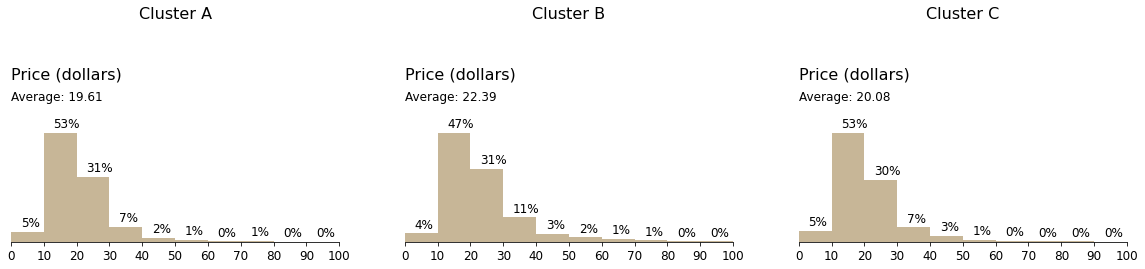

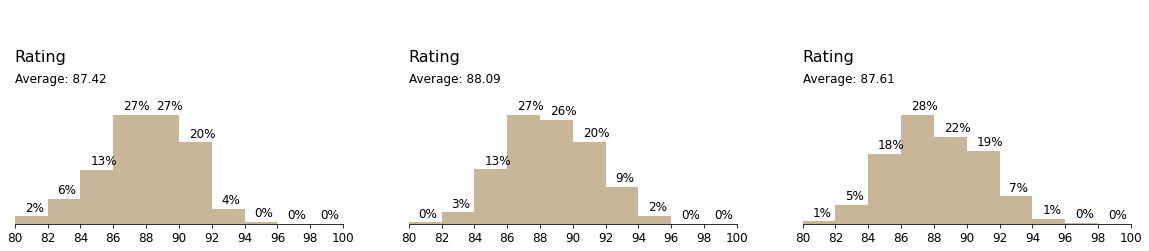

In [55]:
# cluster_labels = [0, 1, 4]

fig = plt.figure(figsize=(20, 4))
for n, cluster in enumerate(cluster_labels):
    plt.subplot(1, len(cluster_labels), n+1)
    generate_histogram(clustered_wines.loc[clustered_wines['cluster_label'] == cluster], 
                       variable='Price', min_value=0, max_value=100, title='Price (dollars)', color='#916e31', binsize=10)
    cluster_title = 'Cluster ' + string.ascii_lowercase[n].capitalize()
    plt.title(cluster_title, fontsize=16)
plt.show()

fig = plt.figure(figsize=(20, 4))
for n, cluster in enumerate(cluster_labels):
    plt.subplot(1, len(cluster_labels), n+1)
    generate_histogram(clustered_wines.loc[clustered_wines['cluster_label'] == cluster],  
                       variable='Rating', min_value=80, max_value=100, title='Rating', color='#916e31', binsize=10)

plt.show()

Once again, the most noteworthy differences here can be observed between Cluster C and A/B. While Cluster A and B wines are similarly priced and have rougly the same rating, Cluster C wines are about 65% more expensive than A/B wines, on average. This is likely a product of the premium charged on wines from the Burgundy region. 

While we will not get into the (de)merits of the point rating scale for wine at this stage, we can again see Cluster C is very different from Clusters A and B. White Burgundy is held as the gold standard for Chardonnay, and this is reflected by an impressive average rating of almost 90 points for Cluster C wines.

### 5. Synthesis

Now that we have studied our various clusters, let's try to synthesize our findings. Can we find a good descriptive label for each of our clusters?

In [56]:
wine_term_mapping.descriptor_level_1.unique()

array(['fruit', 'body', 'oak', 'acid', 'inorganic', 'microbial',
       'sweetness', 'spice', 'tannin', 'noble rot', 'visual', 'style',
       'alcohol', 'flower', 'herb', 'salinity', 'acid ', nan],
      dtype=object)

In [61]:
categories = ['fruit', 'oak', 'acid', 'body']
# categories = ['fruit', 'oak', 'sweetness', 'body']

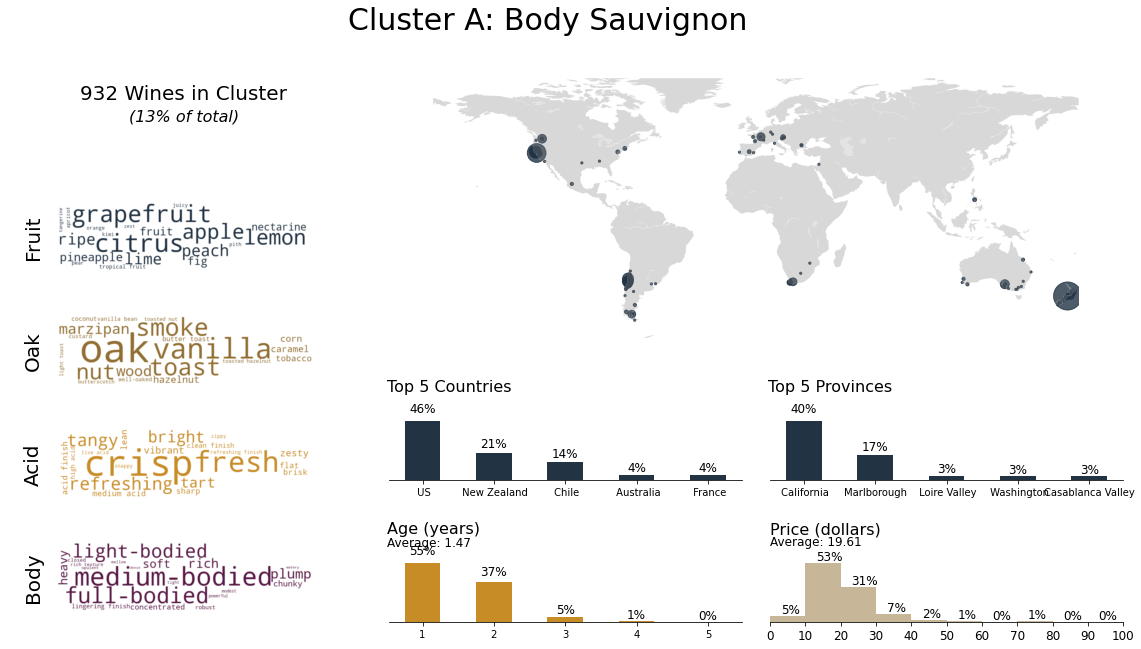

In [62]:
fig = plt.figure(figsize=(20, 10))

generate_cluster_visual(filtered_dataframe=clustered_wines.loc[clustered_wines['cluster_label'] == 0],
                        full_dataframe=clustered_wines, title='Cluster A: Body Sauvignon', categories = categories)

Cluster A contains the majority of the wines in our dataset. These Chardonnays appear to be fruit-forward, with significant notes of apple and pear. There is significant oak on many of these wines, which manifests itself through toast, vanilla and caramel flavors. This is likely the product of American Oak, since the majority of the wines in this cluster are from the US. Other geographies represented in this cluster are France, Chile/Argentina and, to a lesser degree, Australia. 

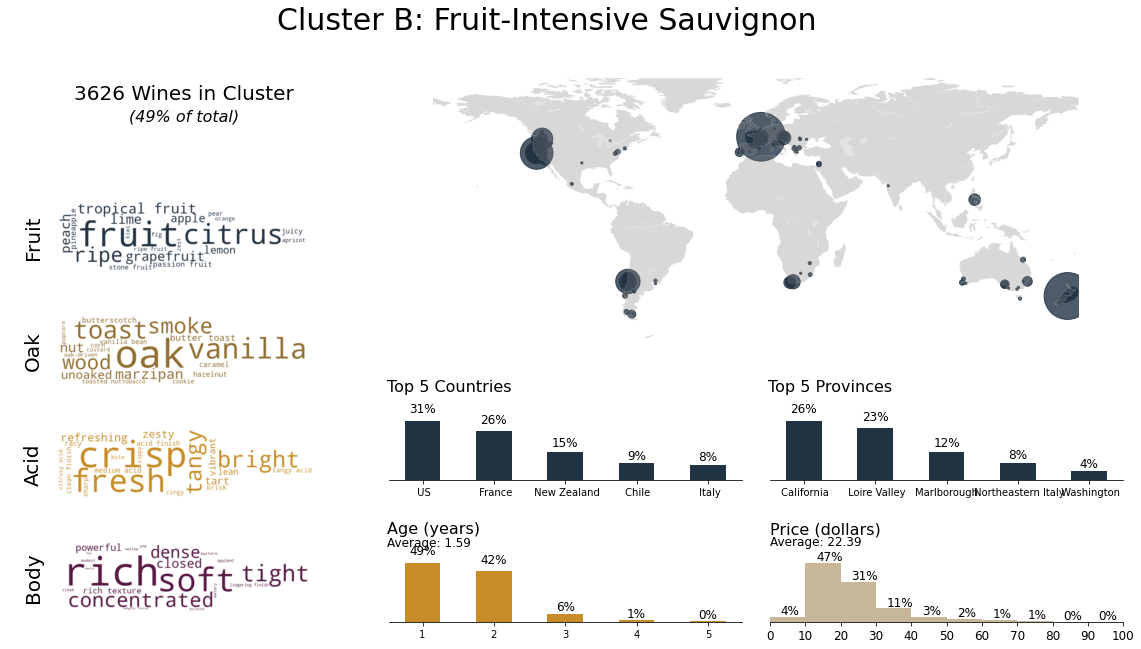

In [63]:
fig = plt.figure(figsize=(20, 10))

generate_cluster_visual(filtered_dataframe=clustered_wines.loc[clustered_wines['cluster_label'] == 1],
                        full_dataframe=clustered_wines, title='Cluster B: Fruit-Intensive Sauvignon', categories = categories)

Cluster B has a similar geographical profile to Cluster A, with most wines coming from California. A noteworthy difference is that Cluster B wines have a greater emphasis on citrus-related fruit descriptors such as lemon, lime and orange. This justifies the name 'Citrus Fruit-Intensive Chardonnay'. Another difference with Cluster A worth pointing out is that it contains proportionally 3x as many wines from Australia. It would appear that Australian Chardonnays more frequently have citrus-heavy profiles.

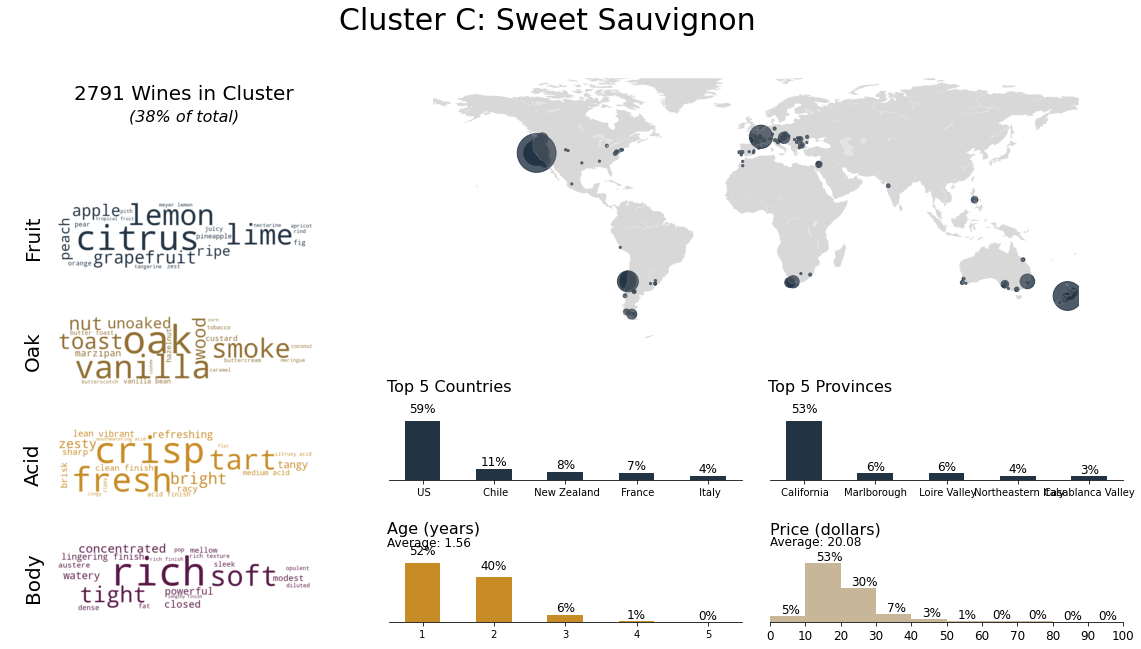

In [64]:
fig = plt.figure(figsize=(20, 10))

generate_cluster_visual(filtered_dataframe=clustered_wines.loc[clustered_wines['cluster_label'] == 2],
                        full_dataframe=clustered_wines, title='Cluster C: Sweet Sauvignon', categories = categories)

Cluster C wines stand out as being French and mainly hail from Burgundy. The proportion of 'body' descriptors is much larger in this Cluster than for other clusters. This may be attributable to the more full-bodied, rich and concentrated nature of these wines. The average price per bottle and average rating of Cluster B wines is notably higher than the other clusters. This may, in part, be a result of the status of White Burgundy as the perceived gold standard of Chardonnay.


### 6. Conclusion

Through this investigative exercise, we were able to identify three main styles of Chardonnay: tree-fruit intensive Chardonnay, citrus-fruit intensive Chardonnay and White Burgundy. These categories are by no means perfect. The average silhouette scores of our clusters suggests that they are defined relatively poorly. We could also have opted for a larger number to capture more of the variation within our dataset. To tackle these problems in a future iteration of this work, we might look to replace the binary features that were generated with a more sophisticated alternative (e.g. word embeddings). We should also remain skeptical about a potential bias underlying all of this work. By using wine reviews as our input, we are assuming that wine reviewers are competent and unbiased agents. It is unclear to what extent reviewers adapt their language to precipitate existing biases about the ways certain wines are supposed to taste.

Nevertheless, this work is an interesting starting point that can help us understand variations of wine within a grape variety. It is noteworthy that an unsupervised clustering task using only wine descriptors was able to create such a strong distinction between French and US Chardonnays. That by itself makes this an interesting area for further analysis. We could look to use the techniques outlined above for other grape varieties too. What are the different types of Pinot Noir, Sauvignon Blanc and Zinfandel? The conclusions extracted from the data in this notebook taste like more...